In [86]:
from ngsolve import *
#from ngsolve.webgui import Draw
from netgen.occ import *
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

def matvec_b(v):
    tmp1.data = v
    tmp2.data = b * tmp1
    return tmp2.FV().NumPy()


def matvec_c(v):
    tmp3.data = v
    tmp4.data = c.mat * tmp3
    return tmp4.FV().NumPy()

In [87]:
def edge_length(e, mesh):
    p1 = mesh.__getitem__(e.vertices[1]).point
    p0 = mesh.__getitem__(e.vertices[0]).point
    e_len = sqrt((p1[0] - p0[0])**2 + (p1[1] - p0[1])**2)
    return e_len

def append_next_edge(edges, prev_edge, mesh, vi, v2):
    for el in prev_edge.elements:
        el = mesh.__getitem__(el)
        for next_e in el.edges:
            next_e = mesh.__getitem__(next_e)
            if (next_e not in edges) and (vi in next_e.vertices) and (v2 not in next_e.vertices):
                edges.append(next_e)
                return
            
def get_ref_edge(central_edge, mesh, vi, v2):
    for el in central_edge.elements:
        el = mesh.__getitem__(el)
        for next_e in el.edges:
            next_e = mesh.__getitem__(next_e)
            if (vi in next_e.vertices) and (v2 in next_e.vertices):
                return next_e

In [88]:
def HDiv_Primal_Dual_L2IP(mesh):
    pe = mesh.edges
    ne = mesh.nedge
    pv = mesh.vertices
    nv = len(pv)
    #Setup

    #for fine to coarse mapping

    elnrs = np.ones((ne,2),dtype=int)
    for e in mesh.edges:
        el1 = mesh.__getitem__(e.elements[0])
        elnrs[e.nr,:] = el1.nr
        if len(e.elements) == 2:
            el2 = mesh.__getitem__(e.elements[1])
            elnrs[e.nr,1] = el2.nr

    #print(elnrs[:,:])

    #Barycentric Refinement
    mesh.ngmesh.SplitPowellSabin()

    #for fine to coarse mapping
    fes_primal = Compress(HCurl(mesh, order=1, type1=True, dirichlet="bottom|right|top|left"))

    Hdiv_u = fes_primal.TrialFunction()
    Hdiv_v = fes_primal.TestFunction()

    #for mapping to dual
    fes_dual =  Compress(HDiv(mesh, order=0, RT=True, dirichlet="bottom|right|top|left"))

    Hdual_u = fes_dual.TrialFunction()
    Hdual_v = fes_dual.TestFunction()

    #L2 inner product of H1 and L2 basis function on barycentrically refined mesh
    HD_HC_L2IP = BilinearForm(trialspace=fes_primal, testspace=fes_dual) #fes_dual)
    HD_HC_L2IP += Hdiv_u * Hdual_v * dx

    HD_HC_L2IP.Assemble()
    #print(HD_HC_L2IP.mat.shape)

    rows,cols,vals  = HD_HC_L2IP.mat.COO()

    mat = sp.sparse.csr_matrix((vals,(rows,cols)))
    #print(mat.shape)

    # mapping to dual ---------------------------------------------------------------------------------------------------------
    data_length = 0
    for e in pe:
        for v in e.vertices:
            v = mesh.__getitem__(v)
            data_length += len(v.edges) + 4

    data = np.zeros(data_length)
    row_ind = np.zeros(data_length, dtype=int)
    col_ind = np.zeros(data_length, dtype=int)

    j = 0

    for e in pe:
        #getting accesible information
        parent = e.nr  
        v0 = e.vertices[0]  
        v1 = e.vertices[1] 
        v0 = mesh.__getitem__(v0)
        v1 = mesh.__getitem__(v1)

        bnd_edge = False
        if elnrs[parent, 0] == elnrs[parent,1]:
            bnd_edge = True

        #finding the central dual edges of the reference edge
        central_edges = []

        for el0 in v0.elements:
            for el1 in v1.elements:
                el0 = mesh.__getitem__(el0)
                el1 = mesh.__getitem__(el1)
                intersect = tuple(set(el0.edges).intersection(el1.edges))
                if intersect != ():
                    e = mesh.__getitem__(intersect[0])
                    central_edges.append(e)

        #finding vertex in edge midpoint
        if len(central_edges) == 2:
            v2 = tuple(set(central_edges[0].vertices).intersection(central_edges[1].vertices))[0]
            v2 = mesh.__getitem__(v2)
        else:
            for v in central_edges[0].vertices:
                v = mesh.__getitem__(v)
                if len(v.faces) == 2:
                    v2 = v

        # #############################################################
        # if len(central_edges) == 2:
        #     v3 = mesh.__getitem__(central_edges[0].vertices[1])
        #     assert(v3 != v2 and v3.nr > v2.nr)
        #     vecA = [v1.point[0] - v0.point[0], v1.point[1] - v0.point[1]]
        #     vecB = [v3.point[0] - v2.point[0], v3.point[1] - v2.point[1]]

        #     if vecA[0] * vecB[1] - vecA[1] * vecB[0] > 0:
        #         tmp = central_edges[0]
        #         central_edges[0] = central_edges[1]
        #         central_edges[1] = tmp
        # ###############################################################


        #setting the coefficients for the edges
        verts = [v0,v1]
        sign = [1, -1]
        if bnd_edge == False:
            for k in range(2):
                vi = verts[k]
                Nc = len(vi.faces)/2
                Ne = len(vi.edges)

                bnd_vertex = False
                for bnd_el in mesh.Elements(BND):
                    if vi in bnd_el.vertices:
                        bnd_vertex = True

                s = sign[k]
                edges = []

                if bnd_vertex == False:
                    #INTERNAL vertex ---------------------------------------------------------------------
                    edges = [central_edges[k]]
                    
                    i = 0    
                    for e_i in edges:            
                        
                        #calculate edge length
                        e_len = edge_length(e_i, mesh)
                        coeff = (Nc - i)/(2*e_len*Nc) 
                        row_ind[j] = parent
                        col_ind[j] = fes_dual.GetDofNrs(e_i)[0]
                        data[j] = coeff *s
                        j += 1

                        append_next_edge(edges, e_i, mesh, vi, v2)
                        i += 1
                else:
                    #BND vertex --------------------------------------------------------------------------
                    #deal with reference edge (part of original edge)
                    ref_edge = get_ref_edge(central_edges[0], mesh, vi, v2)
                    e_len = edge_length(ref_edge, mesh)
                    coeff = (2 - Nc)/(2*e_len*Nc) 
                    row_ind[j] = parent
                    col_ind[j] = fes_dual.GetDofNrs(ref_edge)[0]
                    data[j] = coeff *s
                    j += 1

                    #deal with central edge
                    e_len = edge_length(central_edges[k], mesh)
                    coeff = (1)/(2*e_len) 
                    row_ind[j] = parent
                    col_ind[j] = fes_dual.GetDofNrs(central_edges[k])[0]
                    data[j] = coeff *s
                    j += 1

                    #edges with counterclockwise lower index than ref edge
                    append_next_edge(edges, central_edges[k-1], mesh, vi, v2)
                    for e_i in edges:            
                        #calculate edge length
                        e_len = edge_length(e_i, mesh)
                        coeff = (1-Nc)/(e_len*Nc) 
                        row_ind[j] = parent
                        col_ind[j] = fes_dual.GetDofNrs(e_i)[0]
                        data[j] = coeff * s 
                        j += 1

                        append_next_edge(edges, e_i, mesh, vi, v2)
                    
                    #edges with counterclockwise higher index than ref edge
                    edges = []
                    append_next_edge(edges, central_edges[k], mesh, vi, v2)
                    for e_i in edges:            
                        #calculate edge length
                        e_len = edge_length(e_i, mesh)
                        coeff = (1)/(e_len*Nc) 
                        row_ind[j] = parent
                        col_ind[j] = fes_dual.GetDofNrs(e_i)[0]
                        data[j] = coeff * s
                        j += 1

                        append_next_edge(edges, e_i, mesh, vi, v2)
        #BND Edges ------------------------------------------------------------
        else:
            #deal with the one central edge
            e_len = edge_length(central_edges[0], mesh)
            coeff = (1)/(2*e_len) 
            row_ind[j] = parent
            col_ind[j] = fes_dual.GetDofNrs(central_edges[0])[0]
            data[j] = coeff * -1
            j += 1

            for k in range(2):
                vi = verts[k]       
                s = sign[k]     
                Nc = len(vi.faces)/2
            
                #deal with reference edge (part of original edge)
                ref_edge = get_ref_edge(central_edges[0], mesh, vi, v2)
                e_len = edge_length(ref_edge, mesh)
                coeff = (2 - Nc)/(2*e_len*Nc) 
                row_ind[j] = parent
                col_ind[j] = fes_dual.GetDofNrs(ref_edge)[0]
                data[j] = coeff * s
                j += 1

                numerator = [(1-Nc), (1)]
                edges = []
                append_next_edge(edges, central_edges[0], mesh, vi, v2)
                for e_i in edges:            
                    #calculate edge length
                    e_len = edge_length(e_i, mesh)
                    coeff = numerator[k]/(e_len*Nc) 
                    row_ind[j] = parent
                    col_ind[j] = fes_dual.GetDofNrs(e_i)[0]
                    data[j] = coeff * s 
                    j += 1

                    append_next_edge(edges, e_i, mesh, vi, v2)
        
    dual_map = sp.sparse.csr_matrix((data,(row_ind,col_ind)))#la.SparseMatrixdouble.CreateFromCOO(row_ind,col_ind,data, ne,mesh.nedge - ne)
    #print(dual_map.shape)

    # mapping to coarse primal ---------------------------------------------------------------------------------------------------------

    data_length = 24 * ne

    data = np.zeros(data_length)
    row_ind = np.zeros(data_length, dtype=int)
    col_ind = np.zeros(data_length, dtype=int)

    j = 0

    for e in pe:
        parent = e.nr  
        #print(parent)
        v0 = e.vertices[0]  
        v1 = e.vertices[1] 
        v0 = mesh.__getitem__(v0)
        v1 = mesh.__getitem__(v1)
        verts = [v0,v1]
        coeffs = [-1,1]

        i = 1
        for vi in verts:
            for el in vi.elements:
                if mesh.ngmesh.MacroElementNr(el.nr) == elnrs[parent,0] or mesh.ngmesh.MacroElementNr(el.nr) == elnrs[parent,1]:
                    el = mesh.__getitem__(el)
                    for child in el.edges:
                        
                        child = mesh.__getitem__(child)
                        if len(child.elements) == 2:
                            
                            par_el1 = mesh.ngmesh.MacroElementNr(child.elements[0].nr)
                            par_el2 = mesh.ngmesh.MacroElementNr(child.elements[1].nr)

                            #same parent element
                            if  par_el1 == par_el2:
                                row_ind[j] = parent
                                col_ind[j] = fes_primal.GetDofNrs(child)[0]
                                data[j] = coeffs[i] * 1/6
                                j += 1
                            #different parent, but both are elements of parent edge (the children of the original edge fulfill this)
                            elif par_el1 != par_el2 and (par_el1 == elnrs[parent,0] or par_el1 == elnrs[parent,1]) and (par_el2 == elnrs[parent,0] or par_el2 == elnrs[parent,1]):
                                row_ind[j] = parent
                                col_ind[j] = fes_primal.GetDofNrs(child)[0]
                                data[j] = coeffs[i] * 3/12
                                j += 1
                        #boundry
                        elif len(child.elements) == 1:
                            #the edge midpoint always has higher number than the coarse vertices, s it will always be at index 1
                            v2 = child.vertices[1]
                            v2 = mesh.__getitem__(v2)
                            #the edges which correspond to the original edge in case it was on a boundry,
                            #check if this vertex shares an edge with the other vertex of the original edge
                            #this excludes boundry edges that arent part of the original edge
                            otherv = verts[i]
                            if(set(v2.edges).intersection(otherv.edges) != set()):
                                row_ind[j] = parent
                                col_ind[j] = fes_primal.GetDofNrs(child)[0]
                                data[j] = coeffs[i] * 3/6
                                j += 1 
            i -= 1     

    primal_map = sp.sparse.csr_matrix((data,(row_ind,col_ind)))#la.SparseMatrixdouble.CreateFromCOO(row_ind,col_ind,data, ne,mesh.nedge - ne)
    #print(primal_map.shape)

    dual_L2IP = dual_map @ mat @ primal_map.T

    coo = dual_L2IP.tocoo(copy=True)

    NG_dual = la.SparseMatrixdouble.CreateFromCOO(coo.row,coo.col,coo.data, ne, ne)

    return NG_dual


# netgen_mesh = unit_square.GenerateMesh(maxh=0.5, segmentsperedge=1+1.2, grading=0.1)

# mesh = Mesh(netgen_mesh)

# matrix = HDiv_Primal_Dual_L2IP(mesh)

# print(matrix.shape)
# print(matrix.ToDense())

In [89]:
#l is number of meshwidths, the n-th meshwidth is 1/(2^(n-1))
l = 4
meshwidths = np.ones(l) *0.5
for h in range(l-1):
    meshwidths[h+1] = meshwidths[h]/2

print(meshwidths)
#order for which the elements corresponds to the whitney forms
low_order = 1

#amount of orders for the high-Order space
high_orders = 3 
#array storing the minimal Eigenvalue for given orders and meshwidth
minEV = np.zeros((high_orders,l))

bnd = 'bottom|top|right|left'

lowest_high_Order = low_order + 1
    #largest high order to test
highest_high_order = lowest_high_Order + high_orders

for i in range(lowest_high_Order, highest_high_order):
    print("polynomal order of low order space:", low_order, ", polynomal order of high order space:", i)
    for k in range(l):
        mw = meshwidths[k]
        print("h=",mw)
        Draw(mesh)

        netgen_mesh = unit_square.GenerateMesh(maxh=1)
        mesh=Mesh(netgen_mesh)

        for s in range(k+1):
            mesh.Refine()

        # barycentric refinement crashes programm if mesh hierarchy isnt deleted, 
        # which can be done by saiving and loading the mesh
        mesh.ngmesh.Save("mesh")
        del mesh
        mesh = Mesh("mesh.vol.gz")

        mesh._updateBuffers()

        netgen_dual = mesh.ngmesh.Copy()
        dual_mesh=Mesh(netgen_dual)

        #actual meshwidth
        elvol = Integrate(CoefficientFunction(1),mesh,element_wise=True)
        mesh_h = [(2*vol)**(1/2) for vol in elvol]
        print("actual meshwidth range",min(mesh_h),max(mesh_h), "\n")

        #set function space, for l=0 its normal lagrangian finite elements
        #need to compress to remove DOFs of unrefined mesh after refinement
        H_h = Compress(HCurl(mesh, order = low_order, type1=True, complex=False, dirichlet=bnd)) # main function space
        w_h = GridFunction(H_h) #define vector for matvec wrapper
        H_H = Compress(HCurl(mesh, order=i, type1=True, complex=False, dirichlet=bnd)) # high order Function space for Riesz representative  

        print("# DoFs of low order space:", H_h.ndof, ", # DoFs of high order space:", H_H.ndof)

        #low order
        u_h = H_h.TrialFunction() # define the trial function
        v_h = H_h.TestFunction() # define the test function
        #High order
        u_H = H_H.TrialFunction() # define the trial function
        v_H= H_H.TestFunction() # define the test function

        a = BilinearForm(H_H, symmetric=True, symmetric_storage=False) # define the HDiv inner product on the high order space
        a += curl(u_H) * curl(v_H) * dx
        a += u_H*v_H * dx 
        a.Assemble()

        # m = BilinearForm(H_h) # define the L2 inner product on the low order space
        # m += u_H*v_H * dx 
        # m.Assemble()

        #mass matrix with mixed basis functions
        a_mixed = BilinearForm(trialspace=H_h, testspace=H_H)
        a_mixed += u_h*v_H*dx
        a_mixed.Assemble()

        m_dual = HDiv_Primal_Dual_L2IP(dual_mesh)

        #compute inverses 
        a_inv = a.mat.Inverse(freedofs=H_H.FreeDofs())
        #m_inv = m.mat.Inverse(freedofs=H_h.FreeDofs())

        #create Matrices for GEV problem

        #c is the low order galerkin matrix
        c = BilinearForm(H_h, symmetric=True, symmetric_storage=False)
        c += curl(u_h) * curl(v_h) * dx
        c += u_h*v_h * dx 

        c.Assemble()

        m_dual_inv = m_dual.Inverse(freedofs=H_h.FreeDofs())

        # b is the Matrix that lets us compute the norm of the Riesz representative
        
        b = c.mat.T @ m_dual_inv.T @ a_mixed.mat.T @ a_inv @ a_mixed.mat @ m_dual_inv @ c.mat

        tmp1 = w_h.vec.CreateVector()
        tmp2 = w_h.vec.CreateVector()

        tmp3 = w_h.vec.CreateVector()
        tmp4 = w_h.vec.CreateVector()

        B = sp.sparse.linalg.LinearOperator((b.height,b.width), matvec_b)
        C = sp.sparse.linalg.LinearOperator((c.mat.height,c.mat.width), matvec_c)            

        #The matrices Involved are Symmetric, so the symmetric solver is used
        #look for largest Eigenvalue of Bx = λCx, since ARPACK is more efficient for large EV's
        lam = sp.sparse.linalg.eigsh(B, k=1, M=C, which='LM', return_eigenvectors=False)
        print(lam)
        #if FEM space is complex need to take absolut value (the EV's have no imaginary part, but are still datatype complex)        
        #lam = np.abs(lam)
        #1/λ is the smallest EV of Cx = λBx
        minEV[i-lowest_high_Order,k] = 1/lam[0]

        print("\n")

print(minEV)

[0.5    0.25   0.125  0.0625]
polynomal order of low order space: 1 , polynomal order of high order space: 2
h= 0.5
actual meshwidth range 0.499999999999999 0.49999999999999917 

# DoFs of low order space: 16 , # DoFs of high order space: 48
[1.56736049]


h= 0.25
actual meshwidth range 0.2499999999999995 0.2499999999999996 

# DoFs of low order space: 56 , # DoFs of high order space: 176
[4.10500429]


h= 0.125
actual meshwidth range 0.1249999999999997 0.12499999999999986 

# DoFs of low order space: 208 , # DoFs of high order space: 672
[4.48038928]


h= 0.0625
actual meshwidth range 0.06249999999999981 0.062499999999999986 

# DoFs of low order space: 800 , # DoFs of high order space: 2624
[4.60278393]


polynomal order of low order space: 1 , polynomal order of high order space: 3
h= 0.5
actual meshwidth range 0.499999999999999 0.49999999999999917 

# DoFs of low order space: 16 , # DoFs of high order space: 96
[1.62650178]


h= 0.25
actual meshwidth range 0.2499999999999995 0.2499

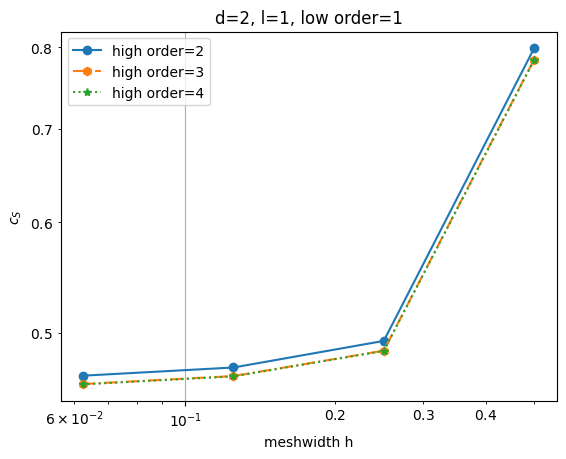

[[0.79875861 0.49356368 0.47243507 0.46611138]
 [0.7841023  0.48570775 0.46582142 0.45976592]
 [0.78345381 0.48546483 0.46557742 0.45953503]]


In [90]:
symbols = ['o-','h-.','*:','+-']


fig, ax = plt.subplots()
plt.rcParams['axes.formatter.min_exponent'] = 1
plt.grid(visible=True)
plt.title(label="d=2, l=1, low order=%i" %low_order)
plt.xlabel('meshwidth h')
plt.ylabel('$c_S$')
#plt.loglog(meshwidths,np.power(meshwidths,2),'--k', label=r'$\mathcal{O}(h^{2})$')

lowest_high_Order = low_order + 1
highest_high_order = lowest_high_Order + high_orders
for i in range(lowest_high_Order,highest_high_order):
    plt.loglog(meshwidths,np.sqrt(minEV[i-lowest_high_Order,:]), symbols[i-lowest_high_Order], label="high order=%i"%i)

plt.legend()

#plt.savefig("d2l1_dual_str_BND.pdf" )

plt.show()

print(np.sqrt(minEV))